#  DQN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://en.wikipedia.org/wiki/Q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/tree/master
* https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/

## Задачи для совместного разбора

1\. Обсудите основные отличия DQN от классических вариантов Q-learning.

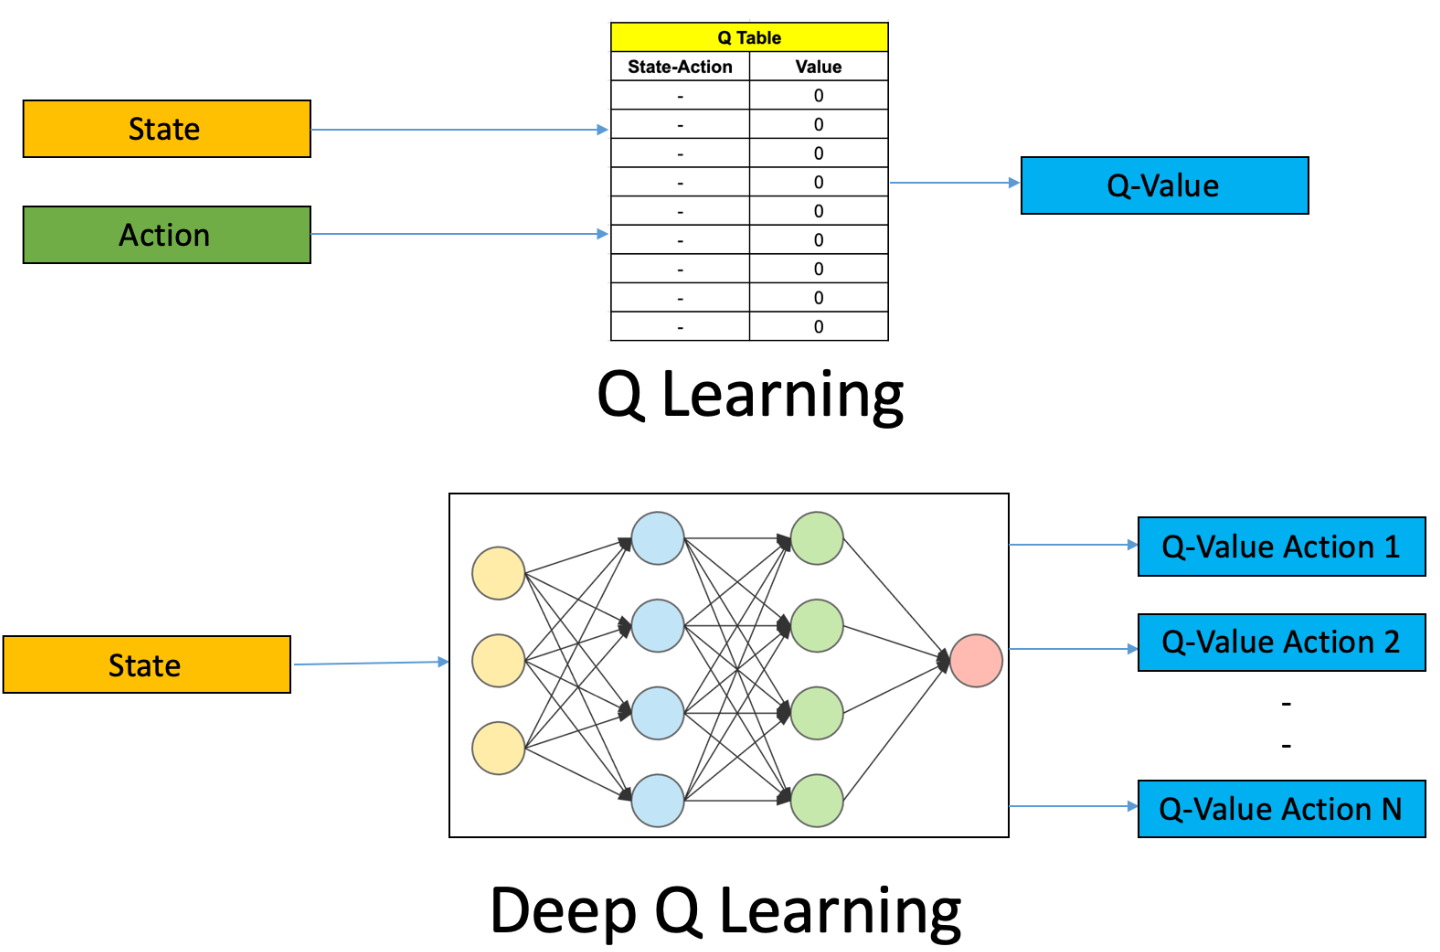

<img src="https://valohai.com/blog/reinforcement-learning-tutorial-part-1-q-learning/image4.png" width="500">
<img src="https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/4.png" width="500">


In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.2 MB/s eta 0:00:00


In [ ]:
import random
from collections import namedtuple, deque
from dataclasses import dataclass
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from gymnasium.wrappers import TransformObservation
import numpy as np

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

### 1\. Допишите класс `ReplayMemory` для хранения переходов между состояниями.

- [ ] Проверено на семинаре

In [ ]:
from collections import namedtuple, deque
# namedtuple - для создания именованных кортежей, чтобы хранить данные о переходе между состояниями
# deque - lдвусторонняя очередь для реализации очереди с ограниченным размером, которая будет использоваться для хранения переходов.

import random

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory:
    def __init__(self, capacity):
        """
        Инициализация памяти.
        :param capacity: Максимальный размер хранилища.
        """
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """
        Сохранение перехода. Удаляет самые старые записи при переполнении.
        :param args: Параметры перехода (state, action, next_state, reward, done).
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Возвращает случайный батч из хранилища.
        :param batch_size: Размер батча.
        :return: Список переходов.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """
        Возвращает количество переходов в памяти.
        :return: Число записей в памяти.
        """
        return len(self.memory)

<p class="task" id="2"></p>

### 2\. Допишите класс `DQN` для моделирования Q-функции.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """
    Нейронная сеть для моделирования Q-функции.
    """
    def __init__(self, n_observations, n_actions):
        """
        Инициализация сети.
        :param n_observations: Размерность входного вектора (количество наблюдений).
        :param n_actions: Количество возможных действий.
        """
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)  # Входной слой
        self.fc2 = nn.Linear(128, 128)            # Скрытый слой
        self.fc3 = nn.Linear(128, n_actions)      # Выходной слой

    def forward(self, x):
        """
        Прямой проход (forward pass) сети.
        :param x: Входные данные (состояния).
        :return: Q-значения для каждого действия.
        """
        x = F.relu(self.fc1(x))  # Активация на первом слое
        x = F.relu(self.fc2(x))  # Активация на втором слое
        return self.fc3(x)       # Выходной слой без активации

<p class="task" id="3"></p>

### 3\. Допишите классы `PolicyConfig` для настроек политики агента и `Policy` для реализации политики.

- [ ] Проверено на семинаре

In [ ]:
# Веса этой сети периодически синхронизируются с весами policy network, но остаются фиксированными на несколько шагов обучения.
# Это помогает стабилизировать процесс обучения, так как цели, к которым стремится policy network, остаются относительно постоянными на некоторое время.

In [ ]:
from dataclasses import dataclass
import torch as th
import torch.nn as nn
import os


@dataclass
class PolicyConfig:
    """
    - размерность пространства наблюдений,
    - количество действий,
    - устройство (CPU/GPU),
    - параметры для ε-жадной стратегии.
    """
    observation_dim: int
    action_dim: int
    device: str = "cpu"
    epsilon_start: float = 1.0
    epsilon_end: float = 0.05
    epsilon_decay: int = 10000


class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        self.cfg = policy_cfg

        # Создаем две версии DQN: policy_network и target_network
        self.policy_network = DQN(self.cfg.observation_dim, self.cfg.action_dim).to(self.cfg.device)  ## и (для оптимизации)
        self.target_network = DQN(self.cfg.observation_dim, self.cfg.action_dim).to(self.cfg.device)  ## сеть используется для предоставления стабильных целей для обучения policy network

        self.sync_models()  # Синхронизируем веса policy_network и target_network

        self.epsilon = self.cfg.epsilon_start
        self.epsilon_decay_rate = (self.cfg.epsilon_start - self.cfg.epsilon_end) / self.cfg.epsilon_decay

    def sync_models(self):
        """
        Синхронизация весов policy_network -> target_network.
        """
        self.target_network.load_state_dict(self.policy_network.state_dict()) # для того, чтобы целевая сеть имела те же самые веса, что и политика, но оставалась неизменной на протяжении нескольких шагов обучения

    def get_best_action(self, state: th.Tensor) -> int:
        """
        Реализует ε-жадную стратегию выбора действия.
        :param state: Текущее состояние в виде тензора.
        :return: Индекс выбранного действия.
        """
        if random.random() < self.epsilon:
            # Выбор случайного действия
            return random.randint(0, self.cfg.action_dim - 1)
        else:
            # Выбор действия на основе policy_network
            with th.no_grad():
                q_values = self.policy_network(state.to(self.cfg.device))
                return th.argmax(q_values).item()

    def update_epsilon(self):
        """
        Обновляет значение ε (уменьшает его на каждом шаге обучения).
        """
        #if self.epsilon > self.cfg.epsilon_end:
        #    self.epsilon -= self.epsilon_decay_rate
        self.epsilon = max(
            self.cfg.epsilon_end,
            self.epsilon * self.cfg.epsilon_decay
        )


    def save(self, filepath="policy.pth"):
        """
        Сохраняет модели на диск.
        """
        th.save({
            'policy_network': self.policy_network.state_dict(),
            'target_network': self.target_network.state_dict(),
        }, filepath)

    def load(self, filepath="policy.pth"):
        """
        Загружает модели с диска.
        """
        if os.path.exists(filepath):
            checkpoint = th.load(filepath, map_location=self.policy_cfg.device)
            self.policy_network.load_state_dict(checkpoint['policy_network'])
            self.target_network.load_state_dict(checkpoint['target_network'])

<p class="task" id="4"></p>

### 4\. Напишите функцию `plot_metrics`, которая будет использоваться для визуализации процесса обучения: суммарной награды за каждый эпизод и максимальное значение x-координаты машины за эпизод. Для реализации можете воспользоваться `tensorboard` или любым другим удобным инструментом.

- [ ] Проверено на семинаре

In [ ]:
def plot_metrics(episode_rewards, max_x_coords, success_rates, interval=100):

    def count_avgs(vals, intrl):
        vals = [_.cpu().item() if isinstance(_, th.Tensor) else _ for _ in vals]
        return [np.mean(vals[i:i + intrl]) for i in range(0, len(vals), intrl)]

    avg_rewards = count_avgs(episode_rewards, interval)
    avg_max_x = count_avgs(max_x_coords, interval)
    avg_success_rates = count_avgs(success_rates, interval)

    plt.figure(figsize=(7, 9))

    plt.subplot(3, 1, 1)
    plt.plot(avg_rewards, label=f'cредняя награда')
    plt.ylabel('средняя суммарная награда')
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(avg_max_x, label=f'среднее max значение X', color='orange')
    plt.ylabel('среднее max значение X')
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(avg_success_rates, label=f'средний уровень успеха', color='green')
    plt.xlabel(f'интервал ({interval} эпизодов)')
    plt.ylabel('средний уровень успеха')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

<p class="task" id="5"></p>

### 5\. Допишите классы `TrainConfig` для настроек обучения и `Trainer` для реализации процесса обучения.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class TrainConfig:
    discount: float
    lr: float
    total_episodes: int
    batch_size: int  # размер батча для обновления модели
    sync_frequency: int  # частота синхронизации целевой модели
    max_steps: int  # максимальное количество шагов в эпизоде

class Trainer:
    def __init__(self, environment: gym.Env, config: TrainingConfig, policy_model):
        """
        :param environment: среда OpenAI Gym
        :param config: настройки обучения
        :param policy_model: модель агента (с политикой)
        """
        self.env = environment
        self.cfg = config
        self.policy = policy_model
        self.replay_buffer = ReplayMemory(100_000)  # память для хранения переходов состояний
        self.optimizer = optim.Adam(self.policy.policy_network.parameters(), lr=self.cfg.lr)
        self.loss_function = nn.MSELoss()  # функция ошибки
        self.best_total_reward = -float('inf')  # лучшая награда
        self.rewards_per_episode = []
        self.max_x_positions = []
        self.success_rates = []

    def train(self):
        progress_bar = tqdm(range(self.cfg.total_episodes), desc="Training Progress", unit="episode")
        for episode in progress_bar:
            # Сброс состояния среды
            initial_state, _ = self.env.reset()
            current_state = (
                th.tensor(initial_state, dtype=th.float32, device=self.policy.cfg.device).unsqueeze(0)
                if not isinstance(initial_state, th.Tensor)
                else initial_state.clone().detach().to(self.policy.cfg.device).unsqueeze(0)
            )

            # Запуск 1 эпизода
            total_reward, max_x_position = self.run_single_episode(current_state)

            # Логирование статистики
            self.rewards_per_episode.append(total_reward)
            self.max_x_positions.append(max_x_position)
            self.success_rates.append(1 if total_reward > -200 else 0)

            # Сохранение лучшей модели
            if total_reward > self.best_total_reward:
                self.best_total_reward = total_reward
                self.save_model()

            # Обновление коэффициента ε для ε-жадной стратегии
            self.policy.update_epsilon()

            # Синхронизация модели с целевой моделью
            if episode % self.cfg.sync_frequency == 0:
                self.policy.sync_models()

            # Вывод промежуточной статистики каждые 100 эпизодов
            if (episode + 1) % 100 == 0:
                avg_reward = sum(self.rewards_per_episode[-100:]) / 100
                avg_max_x = sum(self.max_x_positions[-100:]) / 100
                success_rate = sum(self.success_rates[-100:]) / 100
                progress_bar.set_postfix({
                    "Эпизод": episode + 1,
                    "Средняя награда": f"{avg_reward:.2f}",
                    "Макс. X": f"{avg_max_x:.2f}",
                    "Успехи": f"{success_rate:.1f}%"
                })

    def run_single_episode(self, initial_state: th.Tensor):
        """
        :param initial_state: начальное состояние среды
        :return: суммарная награда и максимальное значение X за эпизод
        """
        state = initial_state
        episode_reward = 0
        max_x_position = -float('inf')

        for step in range(self.cfg.max_steps):
            # Получение лучшего действия от модели
            action = self.policy.get_best_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            # Преобразование состояния в тензор
            next_state_tensor = (
                th.tensor(next_state, dtype=th.float32, device=self.policy.cfg.device).unsqueeze(0)
                if not isinstance(next_state, th.Tensor)
                else next_state.clone().detach().to(self.policy.cfg.device).unsqueeze(0)
            )

            # Сохранение перехода в буфер
            self.replay_buffer.push(state, action, next_state_tensor, reward, done)

            # Переход к следующему состоянию
            state = next_state_tensor
            episode_reward += reward
            max_x_position = max(max_x_position, next_state[0])

            # Если буфер содержит достаточно данных, обновляем модель
            if len(self.replay_buffer) >= self.cfg.batch_size:
                self.update_model()

            if done:
                break

        return episode_reward, max_x_position

    def update_model(self):
        """
        Генерирует батч данных из буфера и обновляет модель.
        """
        if len(self.replay_buffer) < self.cfg.batch_size:
            return

        # Получение переходов из буфера
        transitions = self.replay_buffer.sample(self.cfg.batch_size)
        batch = Transition(*zip(*transitions))

        # Формирование тензоров для обучения
        states = th.cat(batch.state)
        next_states = th.cat(batch.next_state)
        actions = th.tensor(batch.action, device=self.policy.cfg.device).unsqueeze(1)
        rewards = th.tensor(batch.reward, device=self.policy.cfg.device)
        dones = th.tensor(batch.done, device=self.policy.cfg.device, dtype=th.float32)

        # Вычисление текущих и целевых Q-значений
        current_q_values = self.policy.policy_network(states).gather(1, actions).squeeze()
        next_q_values = self.policy.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.cfg.discount * next_q_values

        # Обучение модели
        self.train_policy_network(states, target_q_values, actions)

    def train_policy_network(self, inputs, targets, actions):
        """
        шаг оптимизации.
        :param inputs: состояния
        :param targets: целевые значения Q
        :param actions: действия
        """
        self.optimizer.zero_grad()
        predicted_q_values = self.policy.policy_network(inputs).gather(1, actions).squeeze()
        loss = self.loss_function(predicted_q_values, targets)
        loss.backward()
        self.optimizer.step()

    def save_model(self):
        """
        Сохраняет текущую модель.
        """
        th.save(self.policy.policy_network.state_dict(), "best_policy_model.pth")


<p class="task" id="6"></p>

### 6\. Настройте модель для управления машиной в окружении `MountainCar-v0`. Для преобразования векторов состояний в тензоры используйте обертку `TransformObservation`. Выведите на экран график с информацией о процессе обучения. При необходимости вставьте скриншоты этих графиков.

- [ ] Проверено на семинаре

In [ ]:
env = gym.make('MountainCar-v0')
env = TransformObservation(env, lambda obs: th.tensor(obs, dtype=th.float32), observation_space=env.observation_space)

train_config = TrainConfig(
    discount=1,
    lr=3e-4,
    total_episodes=1000,
    batch_size=256,
    sync_frequency=20,
    max_steps=200
)

policy_config = PolicyConfig(
    observation_dim = env.observation_space.shape[0],
    action_dim = env.action_space.n,
    device='cuda',
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995
)


policy = Policy(policy_config)
trainer = Trainer(env, train_config, policy)

trainer.train()

Training Progress: 100%|██████████| 1000/1000 [13:05<00:00,  1.27episode/s, Эпизод=1000, Средняя награда=-180.50, Макс. X=0.29, Успехи=0.5%]


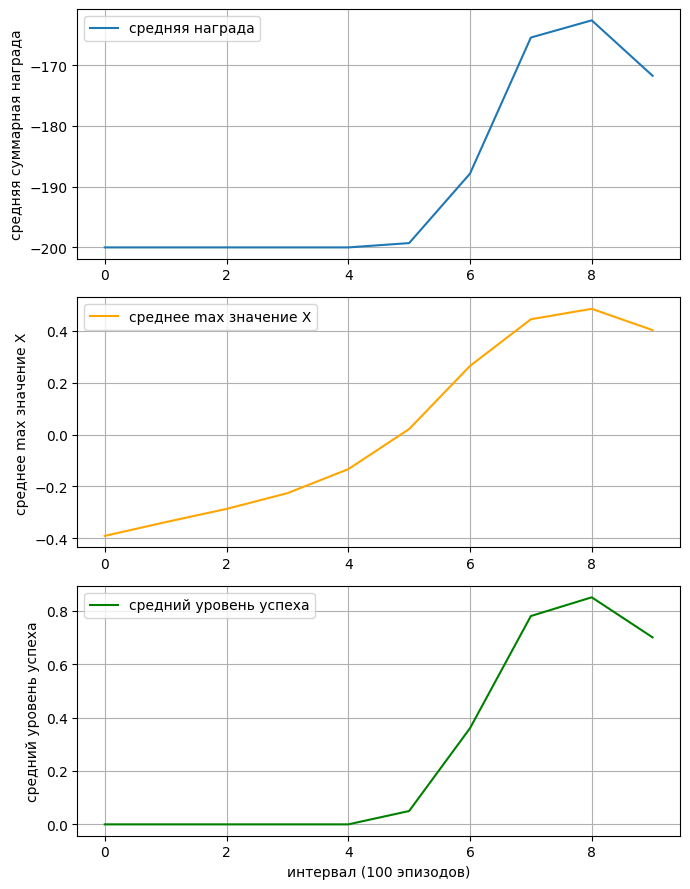

In [ ]:
plot_metrics(trainer.rewards_per_episode, trainer.max_x_positions, trainer.success_rates, interval=100)

In [ ]:
train_config = TrainConfig(
    discount=0.99,
    lr=3e-4,
    total_episodes=5_000,
    batch_size=256,
    sync_frequency=20,
    max_steps=200
)

policy_config = PolicyConfig(
    observation_dim=env.observation_space.shape[0],
    action_dim=env.action_space.n,
    device='cuda',
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995
)


policy = Policy(policy_config)
trainer = Trainer(env, train_config, policy)

trainer.train()

Training: 100%|██████████| 5000/5000 [55:14<00:00,  1.51episode/s, Эпизод=5000, Средн. награда=-120.00, Макс. X=0.51, Успехи=1.0%]


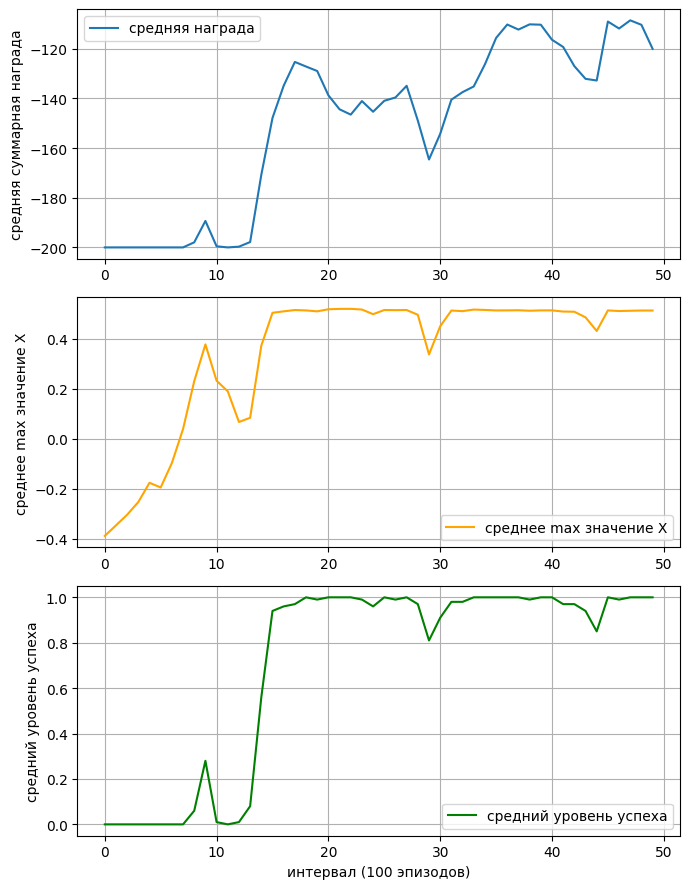

In [ ]:
plot_metrics(trainer.rewards_per_episode, trainer.max_x_positions, trainer.success_rates, interval=100)

<p class="task" id="7"></p>

### 7\. Загрузите состояния моделей из файлов, которые были получены в процессе обучения. Создайте окружение и сыграйте эпизод, используя стратегию, выведенную из обученной Q-функции.

- [ ] Проверено на семинаре

In [ ]:
import gym
from gym.wrappers import RecordVideo

class QAgent:
    """Класс агента для игры, основанного на обученной Q-функции."""
    def __init__(self, q_network):
        self.q_network = q_network
        self.q_network.eval()  # в режим оценки

    def select_action(self, state):
        """
        Выбирает действие на основе текущего состояния.

        :param state: текущее состояние среды
        :return: индекс выбранного действия
        """
        with th.no_grad():
            state = state.view(1, -1)
            q_values = self.q_network(state)  # Вычисление Q-значений
            action = th.argmax(q_values, dim=1).item()  # Выбор действия с максимальным Q
        return action

def load_trained_model(path_to_model, device, input_size, output_size):
    model = DQN(input_size, output_size)
    model.load_state_dict(th.load(path_to_model, map_location=device))
    model.to(device)
    return model

def simulate_episode(env, agent, device):

    state, _ = env.reset()  # Сброс среды и получение начального состояния
    state = th.tensor(state, dtype=th.float32, device=device).unsqueeze(0)
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)  # Шаг в среде
        done = terminated or truncated
        state = th.tensor(next_state, dtype=th.float32, device=device).unsqueeze(0)  # Обновление состояния
        total_reward += reward  # Суммирование награды

    return total_reward

model_file = "best_policy_model.pth"
video_folder = "videos"
device = th.device("cuda" if th.cuda.is_available() else "cpu")

input_dim = 2
output_dim = 3
q_network = load_trained_model(model_file, device, input_dim, output_dim)
agent = QAgent(q_network)  # Создание агента на основе загруженной модели

environment = gym.make("MountainCar-v0", render_mode="rgb_array")
environment = RecordVideo(environment, video_folder, episode_trigger=lambda x: True)

# Запуск эпизода
total_reward = simulate_episode(environment, agent, device)
print(f"Total reward from the episode: {total_reward}")

environment.close()

C:\Users\Work\gpu_env\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\Work\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
C:\Users\Work\gpu_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video C:\Users\Work\video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\Work\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Work\video\rl-video-episode-0.mp4
Total reward from the episode: -189.0


In [ ]:
import base64
from IPython.display import HTML

video_path = "video/rl-video-episode-0.mp4"

with open(video_path, "rb") as video_file:
      video_encoded = base64.b64encode(video_file.read()).decode("utf-8")

video_html = f"""
    <video width="640" height="360" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

HTML(video_html)

## Обратная связь
- [ ] Хочу получить обратную связь по решению